In [1]:
import re
import torch
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np
import pandas as pd
from concurrent.futures import ThreadPoolExecutor 
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

D:\Cardiff University\CMT403 Project\Data-analysis\myven\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('netflix_reviews.csv')

In [3]:
# preprocess data
df = df.dropna(subset=['userName', 'content'])
df = df.drop(columns=['reviewCreatedVersion', 'appVersion'])

def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  
    text = re.sub(r'[^a-zA-Z\s]', '', text) 
    text = text.lower()
    return text

def is_english(text):
    return re.fullmatch(r'[a-zA-Z\s]*', text) is not None

df['cleaned_content'] = df['content'].apply(clean_text)
df = df[df['cleaned_content'].apply(is_english)]
df = df[df['cleaned_content'].str.strip() != '']

# Create sentiment labels
def label_sentiment(score):
    if score >= 4:
        return 'Positive'
    elif score == 3:
        return 'Neutral'
    else:
        return 'Negative'

df['sentiment'] = df['score'].apply(label_sentiment)
df['at'] = pd.to_datetime(df['at'])
df = df[['cleaned_content', 'sentiment', 'at']]

# Convert sentiment labels to numerical values
label_map = {'Positive': 2, 'Neutral': 1, 'Negative': 0}
df['sentiment'] = df['sentiment'].map(label_map)

In [4]:
# BERT processing
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def embed_text(texts, tokenizer, model, max_length=256):
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=max_length)
    with torch.no_grad():
        outputs = model(**inputs)
    cls_embeddings = outputs.last_hidden_state[:, 0, :].detach().cpu().numpy()
    return cls_embeddings

def batch_embed_texts(texts, batch_size=32):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        batch_embeddings = embed_text(batch_texts, tokenizer, model)
        embeddings.append(batch_embeddings)
    return np.vstack(embeddings)

# Get BERT embeddings
texts = df['cleaned_content'].tolist()
batch_size = 32

# Multithreaded parallel processing
with ThreadPoolExecutor() as executor:
    bert_embeddings = np.vstack(list(executor.map(lambda x: embed_text([x], tokenizer, model), texts)))

# Add BERT embeddings to dataframe
df['bert_embeddings'] = list(bert_embeddings)

# Partition dataset by date
split_date = '2024-01-01'
train_df = df[df['at'] < split_date]
test_df = df[df['at'] >= split_date]

# Extract BERT embeddings and sentiment labels
X_train = np.vstack(train_df['bert_embeddings'].values)
y_train = train_df['sentiment'].values
X_test = np.vstack(test_df['bert_embeddings'].values)
y_test = test_df['sentiment'].values


D:\Cardiff University\CMT403 Project\Data-analysis\myven\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [12]:
# BETR + Logistic Regression
bert_model = LogisticRegression(max_iter=1000, class_weight='balanced')
bert_model.fit(X_train, y_train)
y_pred_bert = bert_model.predict(X_test)

print("BERT + Logistic Regression Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_bert) * 100))
print("BERT Logistic Regression Model Report:")
print(classification_report(y_test, y_pred_bert, target_names=['Negative', 'Neutral', 'Positive']))

# TF-IDF + Logistic Regression
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf_train = tfidf_vectorizer.fit_transform(train_df['cleaned_content'])
X_tfidf_test = tfidf_vectorizer.transform(test_df['cleaned_content'])

tfidf_model = LogisticRegression(max_iter=1000, class_weight='balanced')
tfidf_model.fit(X_tfidf_train, y_train)
y_pred_tfidf = tfidf_model.predict(X_tfidf_test)

print("TF-IDF + Logistic Regression Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_tfidf) * 100))
print("TF-IDF Logistic Regression Model Report:")
print(classification_report(y_test, y_pred_tfidf, target_names=['Negative', 'Neutral', 'Positive']))

# Find where BERT is wrong but TF-IDF is correct
bert_wrong_tfidf_correct_indices = np.where((y_pred_bert != y_test) & (y_pred_tfidf == y_test))[0]

# Print reviews where BERT is wrong and TF-IDF is correct
print("\nReviews where BERT Logistic Regression is wrong but TF-IDF Logistic Regression is correct:\n")
for idx in bert_wrong_tfidf_correct_indices:
    print(f"Review: {test_df.iloc[idx]['cleaned_content']}")
    print(f"True Sentiment: {y_test[idx]} (Label: {list(label_map.keys())[list(label_map.values()).index(y_test[idx])]})")
    print(f"BERT Prediction: {y_pred_bert[idx]} (Label: {list(label_map.keys())[list(label_map.values()).index(y_pred_bert[idx])]})")
    print(f"TF-IDF Prediction: {y_pred_tfidf[idx]} (Label: {list(label_map.keys())[list(label_map.values()).index(y_pred_tfidf[idx])]})\n")

D:\Cardiff University\CMT403 Project\Data-analysis\myven\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


BERT + Logistic Regression Accuracy: 75.14%
BERT Logistic Regression Model Report:
              precision    recall  f1-score   support

    Negative       0.91      0.76      0.83      9962
     Neutral       0.18      0.42      0.25      1126
    Positive       0.79      0.81      0.80      4940

    accuracy                           0.75     16028
   macro avg       0.63      0.66      0.63     16028
weighted avg       0.82      0.75      0.78     16028

TF-IDF + Logistic Regression Accuracy: 76.80%
TF-IDF Logistic Regression Model Report:
              precision    recall  f1-score   support

    Negative       0.90      0.79      0.85      9962
     Neutral       0.20      0.43      0.27      1126
    Positive       0.81      0.79      0.80      4940

    accuracy                           0.77     16028
   macro avg       0.64      0.67      0.64     16028
weighted avg       0.83      0.77      0.79     16028


Reviews where BERT Logistic Regression is wrong but TF-IDF Logistic

In [8]:
# BERT + Random Forest
X_train_bert = X_train
X_test_bert = X_test
rf_bert = RandomForestClassifier(n_estimators=100, class_weight='balanced')
rf_bert.fit(X_train_bert, y_train)
y_pred_rf_bert = rf_bert.predict(X_test_bert)

print("BERT + Random Forest Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_rf_bert) * 100))
print("\nBERT + Random Forest Report:")
print(classification_report(y_test, y_pred_rf_bert, target_names=['Negative', 'Neutral', 'Positive']))


# TF-IDF + Random Forest
rf_tfidf = RandomForestClassifier(n_estimators=100, class_weight='balanced')
rf_tfidf.fit(X_tfidf_train, y_train)
y_pred_rf_tfidf = rf_tfidf.predict(X_tfidf_test)

print("TF-IDF + Random Forest Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_rf_tfidf) * 100))
print("\nTF-IDF + Random Forest Report:")
print(classification_report(y_test, y_pred_rf_tfidf, target_names=['Negative', 'Neutral', 'Positive']))

# Define the variable to find where BERT Random Forest is wrong but TF-IDF Random Forest is correct
rf_bert_wrong_tfidf_correct_indices = np.where((y_pred_rf_bert != y_test) & (y_pred_rf_tfidf == y_test))[0]

# Print reviews where BERT Random Forest is wrong and TF-IDF Random Forest is correct
print("\nReviews where BERT Random Forest is wrong but TF-IDF Random Forest is correct:\n")
for idx in rf_bert_wrong_tfidf_correct_indices:
    print(f"Review: {test_df.iloc[idx]['cleaned_content']}")
    print(f"True Sentiment: {y_test[idx]} (Label: {list(label_map.keys())[list(label_map.values()).index(y_test[idx])]})")
    print(f"BERT Random Forest Prediction: {y_pred_rf_bert[idx]} (Label: {list(label_map.keys())[list(label_map.values()).index(y_pred_rf_bert[idx])]})")
    print(f"TF-IDF Random Forest Prediction: {y_pred_rf_tfidf[idx]} (Label: {list(label_map.keys())[list(label_map.values()).index(y_pred_rf_tfidf[idx])]})\n")

BERT + Random Forest Accuracy: 79.60%

BERT + Random Forest Report:
              precision    recall  f1-score   support

    Negative       0.85      0.87      0.86      9962
     Neutral       0.00      0.00      0.00      1126
    Positive       0.71      0.83      0.76      4940

    accuracy                           0.80     16028
   macro avg       0.52      0.57      0.54     16028
weighted avg       0.74      0.80      0.77     16028

TF-IDF + Random Forest Accuracy: 78.99%

TF-IDF + Random Forest Report:
              precision    recall  f1-score   support

    Negative       0.82      0.90      0.86      9962
     Neutral       0.00      0.00      0.00      1126
    Positive       0.72      0.76      0.74      4940

    accuracy                           0.79     16028
   macro avg       0.52      0.55      0.53     16028
weighted avg       0.73      0.79      0.76     16028


Reviews where BERT Random Forest is wrong but TF-IDF Random Forest is correct:

Review: sexual co

D:\Cardiff University\CMT403 Project\Data-analysis\myven\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Cardiff University\CMT403 Project\Data-analysis\myven\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Cardiff University\CMT403 Project\Data-analysis\myven\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

In [10]:
# BERT + XGBoost
xgb_bert = xgb.XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss', use_label_encoder=False)
xgb_bert.fit(X_train_bert, y_train)
y_pred_xgb_bert = xgb_bert.predict(X_test_bert)

print("BERT + XGBoost Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_xgb_bert) * 100))
print("\nBERT + XGBoost Report:")
print(classification_report(y_test, y_pred_xgb_bert, target_names=['Negative', 'Neutral', 'Positive']))


# TF-IDF + XGBoost
xgb_tfidf = xgb.XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss', use_label_encoder=False)
xgb_tfidf.fit(X_tfidf_train, y_train)
y_pred_xgb_tfidf = xgb_tfidf.predict(X_tfidf_test)

print("TF-IDF + XGBoost Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_xgb_tfidf) * 100))
print("\nTF-IDF + XGBoost Report:")
print(classification_report(y_test, y_pred_xgb_tfidf, target_names=['Negative', 'Neutral', 'Positive']))


# Find where BERT XGBoost is wrong but TF-IDF XGBoost is correct
xgb_bert_wrong_tfidf_correct_indices = np.where((y_pred_xgb_bert != y_test) & (y_pred_xgb_tfidf == y_test))[0]

# Print reviews where BERT XGBoost is wrong but TF-IDF XGBoost is correct
print("\nReviews where BERT XGBoost is wrong but TF-IDF XGBoost is correct:\n")
for idx in xgb_bert_wrong_tfidf_correct_indices:
    print(f"Review: {test_df.iloc[idx]['cleaned_content']}")
    print(f"True Sentiment: {y_test[idx]} (Label: {list(label_map.keys())[list(label_map.values()).index(y_test[idx])]})")
    print(f"BERT XGBoost Prediction: {y_pred_xgb_bert[idx]} (Label: {list(label_map.keys())[list(label_map.values()).index(y_pred_xgb_bert[idx])]})")
    print(f"TF-IDF XGBoost Prediction: {y_pred_xgb_tfidf[idx]} (Label: {list(label_map.keys())[list(label_map.values()).index(y_pred_xgb_tfidf[idx])]})\n")

BERT + XGBoost Accuracy: 81.11%

BERT + XGBoost Report:
              precision    recall  f1-score   support

    Negative       0.87      0.88      0.87      9962
     Neutral       0.30      0.04      0.07      1126
    Positive       0.72      0.86      0.79      4940

    accuracy                           0.81     16028
   macro avg       0.63      0.59      0.58     16028
weighted avg       0.78      0.81      0.79     16028



D:\Cardiff University\CMT403 Project\Data-analysis\myven\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


TF-IDF + XGBoost Accuracy: 80.14%

TF-IDF + XGBoost Report:
              precision    recall  f1-score   support

    Negative       0.82      0.93      0.87      9962
     Neutral       0.30      0.02      0.03      1126
    Positive       0.77      0.72      0.75      4940

    accuracy                           0.80     16028
   macro avg       0.63      0.56      0.55     16028
weighted avg       0.77      0.80      0.77     16028


Reviews where BERT XGBoost is wrong but TF-IDF XGBoost is correct:

Review: i do not liked it at all
True Sentiment: 0 (Label: Negative)
BERT XGBoost Prediction: 2 (Label: Positive)
TF-IDF XGBoost Prediction: 0 (Label: Negative)

Review: i hope you fix the bug that logs me out every time i access the app with the error that im not part of the netflix household when im the main owner  thank you
True Sentiment: 0 (Label: Negative)
BERT XGBoost Prediction: 2 (Label: Positive)
TF-IDF XGBoost Prediction: 0 (Label: Negative)

Review:  pradeepd
True Sentiment

BERT XGBoost Prediction: 2 (Label: Positive)
TF-IDF XGBoost Prediction: 0 (Label: Negative)

Review: very bed  please download na kare
True Sentiment: 0 (Label: Negative)
BERT XGBoost Prediction: 2 (Label: Positive)
TF-IDF XGBoost Prediction: 0 (Label: Negative)

Review: im asking if you can make  profile please
True Sentiment: 2 (Label: Positive)
BERT XGBoost Prediction: 0 (Label: Negative)
TF-IDF XGBoost Prediction: 2 (Label: Positive)

Review: no one oo km mn k ssx f
True Sentiment: 0 (Label: Negative)
BERT XGBoost Prediction: 2 (Label: Positive)
TF-IDF XGBoost Prediction: 0 (Label: Negative)

Review: why it has payment 
True Sentiment: 0 (Label: Negative)
BERT XGBoost Prediction: 2 (Label: Positive)
TF-IDF XGBoost Prediction: 0 (Label: Negative)

Review: worst and costliest
True Sentiment: 0 (Label: Negative)
BERT XGBoost Prediction: 2 (Label: Positive)
TF-IDF XGBoost Prediction: 0 (Label: Negative)

Review: very to stard
True Sentiment: 0 (Label: Negative)
BERT XGBoost Prediction:

Epoch 1/5
2699/2699 [==============================] - 38s 12ms/step - loss: 0.6200 - accuracy: 0.7652 - val_loss: 0.4776 - val_accuracy: 0.8278
Epoch 2/5
2699/2699 [==============================] - 31s 12ms/step - loss: 0.5928 - accuracy: 0.7744 - val_loss: 0.4830 - val_accuracy: 0.8275
Epoch 3/5
2699/2699 [==============================] - 30s 11ms/step - loss: 0.5859 - accuracy: 0.7767 - val_loss: 0.4721 - val_accuracy: 0.8303
Epoch 4/5
2699/2699 [==============================] - 30s 11ms/step - loss: 0.5797 - accuracy: 0.7791 - val_loss: 0.4742 - val_accuracy: 0.8318
Epoch 5/5
2699/2699 [==============================] - 30s 11ms/step - loss: 0.5735 - accuracy: 0.7810 - val_loss: 0.4735 - val_accuracy: 0.8313
Epoch 1/5
5398/5398 [==============================] - 70s 12ms/step - loss: 0.5996 - accuracy: 0.7708 - val_loss: 0.4833 - val_accuracy: 0.8247
Epoch 2/5
5398/5398 [==============================] - 60s 11ms/step - loss: 0.5645 - accuracy: 0.7833 - val_loss: 0.4785 - val_ac

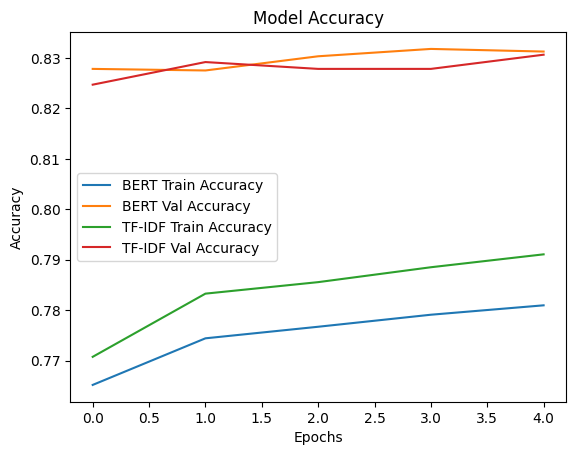

BERT 错误但 TF-IDF 正确的评论:
                                          cleaned_content  sentiment
63                               i do not liked it at all          0
81      i thought that all of the old and new movie is...          0
100                                       pro zionist app          0
105                          who am i think and awnser me          2
125                            login problem login atemet          0
...                                                   ...        ...
111822                                     have many bugs          0
111952         moneygrubbing poop stains run this company          0
111965                         k i log ft dl my ty why hi          2
112021   you know what to do with your household features          0
112028                                nothing new all old          0

[658 rows x 2 columns]


In [5]:
# LSTM
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf_features = tfidf_vectorizer.fit_transform(df['cleaned_content'])

X_train_bert = np.vstack(train_df['bert_embeddings'].values)
X_test_bert = np.vstack(test_df['bert_embeddings'].values)
y_train = train_df['sentiment'].values
y_test = test_df['sentiment'].values

X_train_tfidf = tfidf_features[df['at'] < split_date]
X_test_tfidf = tfidf_features[df['at'] >= split_date]

X_train_tfidf = X_train_tfidf.astype('float32')
X_test_tfidf = X_test_tfidf.astype('float32')

X_train_bert = np.expand_dims(X_train_bert, axis=1)
X_test_bert = np.expand_dims(X_test_bert, axis=1)


def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

# BERT + LSTM
model_bert = build_lstm_model((X_train_bert.shape[1], X_train_bert.shape[2]))
history_bert = model_bert.fit(X_train_bert, y_train, epochs=5, batch_size=32, validation_split=0.1, verbose=1)

# TF-IDF + BERT
X_train_tfidf = X_train_tfidf.toarray()  
X_test_tfidf = X_test_tfidf.toarray()

X_train_tfidf = np.expand_dims(X_train_tfidf, axis=1)
X_test_tfidf = np.expand_dims(X_test_tfidf, axis=1)

model_tfidf = build_lstm_model((X_train_tfidf.shape[1], X_train_tfidf.shape[2]))
history_tfidf = model_tfidf.fit(X_train_tfidf, y_train, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

y_pred_bert = np.argmax(model_bert.predict(X_test_bert), axis=1)
y_pred_tfidf = np.argmax(model_tfidf.predict(X_test_tfidf), axis=1)

accuracy_bert = accuracy_score(y_test, y_pred_bert)
accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)

print(f"BERT LSTM Model Accuracy: {accuracy_bert:.4f}")
print(f"TF-IDF LSTM Model Accuracy: {accuracy_tfidf:.4f}")

plt.plot(history_bert.history['accuracy'], label='BERT Train Accuracy')
plt.plot(history_bert.history['val_accuracy'], label='BERT Val Accuracy')
plt.plot(history_tfidf.history['accuracy'], label='TF-IDF Train Accuracy')
plt.plot(history_tfidf.history['val_accuracy'], label='TF-IDF Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [6]:
# Reviews where BERT LSTM is wrong but TF-IDF LSTM is correct
bert_wrong_tfidf_right = test_df[(y_pred_bert != y_test) & (y_pred_tfidf == y_test)]

print("Reviews where BERT LSTM is wrong but TF-IDF LSTM is correct:\n")
for index, row in bert_wrong_tfidf_right.iterrows():
    review = row['cleaned_content']
    true_sentiment = row['sentiment']
    bert_prediction = y_pred_bert[index]
    tfidf_prediction = y_pred_tfidf[index]

    label_dict = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    true_label = label_dict[true_sentiment]
    bert_label = label_dict[bert_prediction]
    tfidf_label = label_dict[tfidf_prediction]

    print(f"Review: {review}")
    print(f"True Sentiment: {true_sentiment} (Label: {true_label})")
    print(f"BERT LSTM Prediction: {bert_prediction} (Label: {bert_label})")
    print(f"TF-IDF LSTM Prediction: {tfidf_prediction} (Label: {tfidf_label})\n")


Reviews where BERT LSTM is wrong but TF-IDF LSTM is correct:

Review: i do not liked it at all
True Sentiment: 0 (Label: Negative)
BERT LSTM Prediction: 2 (Label: Positive)
TF-IDF LSTM Prediction: 2 (Label: Positive)

Review: i thought that all of the old and new movie is in the netflix
True Sentiment: 0 (Label: Negative)
BERT LSTM Prediction: 2 (Label: Positive)
TF-IDF LSTM Prediction: 2 (Label: Positive)

Review: pro zionist app
True Sentiment: 0 (Label: Negative)
BERT LSTM Prediction: 0 (Label: Negative)
TF-IDF LSTM Prediction: 2 (Label: Positive)

Review: who am i think and awnser me
True Sentiment: 2 (Label: Positive)
BERT LSTM Prediction: 0 (Label: Negative)
TF-IDF LSTM Prediction: 0 (Label: Negative)

Review: login problem login atemet
True Sentiment: 0 (Label: Negative)
BERT LSTM Prediction: 0 (Label: Negative)
TF-IDF LSTM Prediction: 0 (Label: Negative)

Review: so gooodddd
True Sentiment: 2 (Label: Positive)
BERT LSTM Prediction: 0 (Label: Negative)
TF-IDF LSTM Prediction: 0 

IndexError: index 16096 is out of bounds for axis 0 with size 16028